# ニューラルネット

Python は，豊富なライブラリを備えています。特に，ニューラルネットワークなどの機械学習のライブラリが充実しています。機械学習の仕組みの詳細を知らなくても，データを揃えてライブラリを呼び出せば，ある程度のことができる状態になっています。文字認識のニューラルネットを題材に，その使い方を説明します。

ニューラルネットのライブラリとしては，オープンソースのPyTorch が広く使われています。
その前には、Google が開発したオープンソースのシステムである TensorFlow が有名でした。さらに，Tensorflow のニューラルネットワークを組むための高レベルのライブラリである Keras を用いると，見よう見まねで，ある程度の機械学習を行えます。

ここでは、Tensorflow と Keras を用いて説明をしますが、これから学習する人は、PyTorch を用いることをお勧めします。Tenforflow, Keras, それに、PyTorch も、
標準でインストールされていません。pip を用いてインストールします。
また、Tensorflow と Keras は、python のバージョンを 3.8 下げないとサポートされていない可能性があります。また、MacOS で動かすのに、幾つかエラーに対処する必要がありました。


このソースは，以下のページからとってきたものを，説明用に加工したものです。
このページの解説は十分によく書けているので，これを見て勉強してください。

https://weblabo.oscasierra.net/python/keras-mnist-sample.html


ただし，場合によっては，python のバージョンを下げることが要求されます。
それは，anaconda の画面からはできなそうで，conda コマンドで行います。
```
conda info -e       environment を見ます。
conda activate mnist    mnist にデフォルトの environment を変えます。
conda install python=3.7   python のバージョンを 3.7 に下げます。
conda install tensorflow   tenforflow のインストール
```

In [29]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

In [30]:
# MNISTデータを読込む
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()

mnist は，手書きの数字のテストデータとして広く使われているデータです。mnist モジュールのload_data() の呼び出しで，ネットからダウンロードされ，トレーニング用，テスト用のデータに分けられます。

In [31]:
print(type(raw_x_train), raw_x_train.shape, raw_x_train.dtype)
print(type(raw_y_train), raw_y_train.shape, raw_y_train.dtype)
print(type(raw_x_test), raw_x_test.shape, raw_x_test.dtype)
print(type(raw_y_test), raw_y_test.shape, raw_y_test.dtype)

<class 'numpy.ndarray'> (60000, 28, 28) uint8
<class 'numpy.ndarray'> (60000,) uint8
<class 'numpy.ndarray'> (10000, 28, 28) uint8
<class 'numpy.ndarray'> (10000,) uint8


このように，raw_x_train, raw_x_test には，28x28 の unit 8 の配列がそれぞれ 60000, 10000 枚はいっています。これらが手書きの画像です。unit 8 は，符号なしビットビット整数(0 から 255 まで) です。

raw_y_train, raw_y_test には，unit8 の数が入っています。これは，0 から 9 までのどの文字かを表しています。

次のようにして Pillow で表示できます。
（pillow はインストールされていないなら，インストールしましょう。）

In [32]:
import numpy as np
import PIL.Image as Image

# 文字表示
def show(img):
    img = Image.fromarray(np.uint8(img))
    display(img)   
#    img.show()
    
show(raw_x_train[107]) 
print(raw_y_train[107])

3


この形では，ニューラルネットは扱えないので，次のように加工します。
画像は，0 から 1 の実数を 784 (28x28) 個並べた形にします。
正解データは，その部分だけが 1 の実数データにします（one-hot 表現）。

In [33]:
x_train  = raw_x_train.reshape(60000, 784)
x_test   = raw_x_test.reshape(10000, 784)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255
y_train  = keras.utils.to_categorical(raw_y_train, 10)
y_test   = keras.utils.to_categorical(raw_y_test, 10)

In [34]:
print(type(x_train), x_train.shape, x_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)

<class 'numpy.ndarray'> (60000, 784) float32
<class 'numpy.ndarray'> (60000, 10) float32


In [35]:
print(x_train[0][100:200])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01176471 0.07058824
 0.07058824 0.07058824 0.49411765 0.53333336 0.6862745  0.10196079
 0.6509804  1.         0.96862745 0.49803922 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11764706 0.14117648
 0.36862746 0.6039216  0.6666667  0.99215686 0.99215686 0.99215686
 0.99215686 0.99215686 0.88235295 0.6745098  0.99215686 0.9490196
 0.7647059  0.2509804  0.         0.         0.         0.
 0.         0.   

In [36]:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


ニューラルネットをモデルとして組みます。
最初は，入力層と出力層だけがあり，それが，全結合でつながったもので試しましょう。

In [37]:
# モデルの構築
model = Sequential()
model.add(InputLayer(input_shape=(784,)))
#model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


model.fit により，学習を行いましょう。データを batch_size で指定された長さのバッチに分けて，バッチごとに学習します。学習は行列計算で実現されるので，ある程度の量のデータを一度に処理した方が効率が出ます。

全データに対する学習を，epochs で指定された回数繰り返します。
繰り返すごとに，性能があがっていきます。loss の値が下がり，accuracy の値が上がっていきます。

In [38]:
# 学習
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))


Epoch 1/20
469/469 [==============================] - 0s 704us/step - loss: 0.6075 - accuracy: 0.8489 - val_loss: 0.3418 - val_accuracy: 0.9066
Epoch 2/20
469/469 [==============================] - 0s 577us/step - loss: 0.3309 - accuracy: 0.9084 - val_loss: 0.2978 - val_accuracy: 0.9170
Epoch 3/20
469/469 [==============================] - 0s 575us/step - loss: 0.3019 - accuracy: 0.9156 - val_loss: 0.2846 - val_accuracy: 0.9201
Epoch 4/20
469/469 [==============================] - 0s 576us/step - loss: 0.2883 - accuracy: 0.9193 - val_loss: 0.2776 - val_accuracy: 0.9236
Epoch 5/20
469/469 [==============================] - 0s 579us/step - loss: 0.2804 - accuracy: 0.9220 - val_loss: 0.2741 - val_accuracy: 0.9240
Epoch 6/20
469/469 [==============================] - 0s 588us/step - loss: 0.2744 - accuracy: 0.9240 - val_loss: 0.2723 - val_accuracy: 0.9245
Epoch 7/20
469/469 [==============================] - 0s 594us/step - loss: 0.2706 - accuracy: 0.9257 - val_loss: 0.2732 - val_accuracy:

テストデータで検証します。

In [39]:

# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


313/313 [==============================] - 0s 475us/step - loss: 0.2730 - accuracy: 0.9269

Test loss: 0.27302855253219604
Test accuracy: 0.9269000291824341


In [40]:
show(raw_x_test[0]) 


In [43]:
np.argmax(p, axis=1)

array([7, 2, 1, ..., 4, 5, 6])

In [44]:
p = model.predict(x_test)
ans = np.argmax(p, axis=1)
print(ans[0:100])   # AI の答え

print(raw_y_test[0:100]) # 正解
[i for i in range(100) if (ans[i] != raw_y_test[i])]


313/313 [==============================] - 0s 355us/step
[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 2 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]


[8, 33, 63]

In [47]:
show(raw_x_test[63]) 


In [ ]:
p[0]

array([9.9668057e-08, 3.0119825e-13, 3.7876081e-08, 1.7372594e-03,
       1.1319405e-07, 1.3153890e-05, 2.9575108e-15, 9.9802339e-01,
       1.9598892e-06, 2.2403333e-04], dtype=float32)

In [ ]:
ans[0]

7

In [48]:
a = 66
show(raw_x_test[a])
print(p[a])
print(f"正解={raw_y_test[a]}, AIの答え={ans[a]}")

[4.8215495e-04 1.8624095e-06 4.2227623e-01 9.8831259e-02 2.2078224e-02
 6.5078726e-04 4.4947040e-01 4.9013915e-03 1.2909955e-03 1.6694346e-05]
正解=6, AIの答え=6


ネットワークを組み替えて，より高機能にしましょう。具体的には，モデルに中間層として，全結合で，relu という活性化関数をもったものを追加します。層のセルの数は 128 にしましたが，これが最適かどうかは分かりません。いろんなパラメータ（ハイパーパラメータといいます）を経験に基づいて設定していく必要があります。

In [49]:
# モデルの構築
model2 = Sequential()
model2.add(InputLayer(input_shape=(784,)))
model2.add(Dense(128, activation='relu'))   # この行!!
model2.add(Dense(10, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# 学習
epochs = 20
batch_size = 128
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))


# 検証
score = model2.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/20
469/469 [==============================] - 1s 1ms/step - loss: 0.3325 - accuracy: 0.9090 - val_loss: 0.1853 - val_accuracy: 0.9449
Epoch 2/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1606 - accuracy: 0.9536 - val_loss: 0.1332 - val_accuracy: 0.9605
Epoch 3/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1142 - accuracy: 0.9665 - val_loss: 0.1119 - val_accuracy: 0.9680
Epoch 4/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0894 - accuracy: 0.9737 - val_loss: 0.0965 - val_accuracy: 0.9705
Epoch 5/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0726 - accuracy: 0.9791 - val_loss: 0.0894 - val_accuracy: 0.9726
Epoch 6/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0607 - accuracy: 0.9823 - val_loss: 0.0821 - val_accuracy: 0.9740
Epoch 7/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0517 - accuracy: 0.9845 - val_loss: 0.0878 - val_accuracy: 0.9736
Epoch 

先程より，さらに結果がよくなりました。

学習の過程は，model.fit の返り値(history および history2) に格納されています。
学習過程において，loss (損失値，この値が低いほどよい) と val_loss (テストデータに対する損失値)の値がどう変化したかをグラフ化します。
このコードは，次のページからとってきました。

https://weblabo.oscasierra.net/python/keras-mnist-sample.html

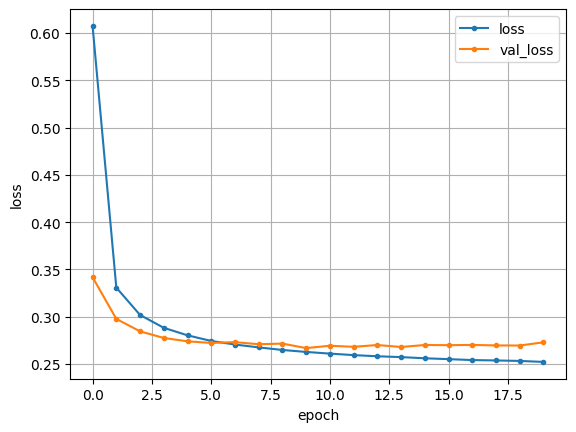

In [50]:
import matplotlib.pyplot as plt

loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

val_loss の値は，一度下がってからまた少し上がっているようです。これは，過学習している（すなわち，訓練データに合わせすぎて汎用性がなくなってきている）と思われます。

history2 も重ねてみましょう。

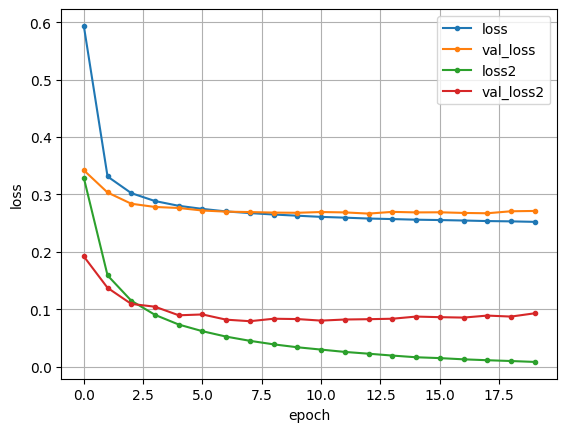

In [ ]:
import matplotlib.pyplot as plt

loss     = history.history['loss']
val_loss = history.history['val_loss']
loss2     = history2.history['loss']
val_loss2 = history2.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.plot(range(nb_epoch), loss2,     marker='.', label='loss2')
plt.plot(range(nb_epoch), val_loss2, marker='.', label='val_loss2')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

訓練データに対しては値がどんどんよくなっているのに，テストデータに対しては悪くなってきているのは，過学習の特徴です。

In [ ]:
p = np.argmax(model.predict(x_test), axis=1)
print(len(list (filter (lambda x: x[0]!=x[1], (zip(p, raw_y_test))))))
print(len(p))
p2 = np.argmax(model2.predict(x_test), axis=1)
print(len(list (filter (lambda x: x[0]!=x[1], (zip(p2, raw_y_test))))))
print(len(p2))

  1/313 [..............................] - ETA: 9s

313/313 [==============================] - 0s 722us/step
737
10000
313/313 [==============================] - 0s 335us/step
229
10000
